# GRAPE for CNOT

In [2]:
# ruff: noqa

"""
Gradient Ascent Pulse Engineering (GRAPE)
"""

import jax
import jax.numpy as jnp
import optax
from grape import optimize_pulse
from utils.gates import cnot
from utils.operators import identity, sigmax, sigmay, sigmaz
from utils.tensor import tensor

# TODO: Implement this with Pavlo's Cavity + Qubit coupled in dispersive regime

# Example usage
g = 0  # Small coupling strength
H_drift = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))
H_ctrl = [
    tensor(sigmax(), identity(2)),
    tensor(sigmay(), identity(2)),
    tensor(sigmaz(), identity(2)),
    tensor(identity(2), sigmax()),
    tensor(identity(2), sigmay()),
    tensor(identity(2), sigmaz()),
    tensor(sigmax(), sigmax()),
    tensor(sigmay(), sigmay()),
    tensor(sigmaz(), sigmaz()),
]

U_0 = identity(4)
# Target operator (CNOT gate)
C_target = cnot()

num_t_slots = 500
total_evo_time = 2 * jnp.pi

# Run optimization
result = optimize_pulse(
    H_drift,
    H_ctrl,
    U_0,
    C_target,
    num_t_slots,
    total_evo_time,
    max_iter=500,
    learning_rate=1e-2,
)
print("final_fidelity: ", result.final_fidelity)
print("U_f \n", result.final_operator)

Iteration 0, _fidelity: 0.2500471121552508
Iteration 10, _fidelity: 0.5678220593197114
Iteration 20, _fidelity: 0.8560683922952129
Iteration 30, _fidelity: 0.9795725312380824
Iteration 40, _fidelity: 0.9835343122554986
Iteration 50, _fidelity: 0.9971964971852708
Iteration 60, _fidelity: 0.9982058068049523
Iteration 70, _fidelity: 0.999453066224202
Iteration 80, _fidelity: 0.9996637840262896
Iteration 90, _fidelity: 0.9999583402892512
Iteration 100, _fidelity: 0.9999744631010252
Converged after 104 iterations.
final_fidelity:  0.9999900579928175
U_f 
 [[ 7.07065541e-01+7.07143872e-01j  1.66168702e-03+7.48447562e-04j
   3.18534044e-05+1.01272593e-03j -8.36044348e-04+9.03708742e-04j]
 [-7.45161326e-04-1.66479432e-03j  7.05754224e-01+7.08446448e-01j
   1.99202832e-03+1.86622258e-04j -2.40131098e-03-1.22905074e-03j]
 [-9.04367116e-04+8.30113981e-04j  1.22678449e-03+2.40418361e-03j
  -6.16205421e-04+1.18843526e-03j  7.07350591e-01+7.06855401e-01j]
 [-1.01444213e-03-2.82513346e-05j -1.9134321

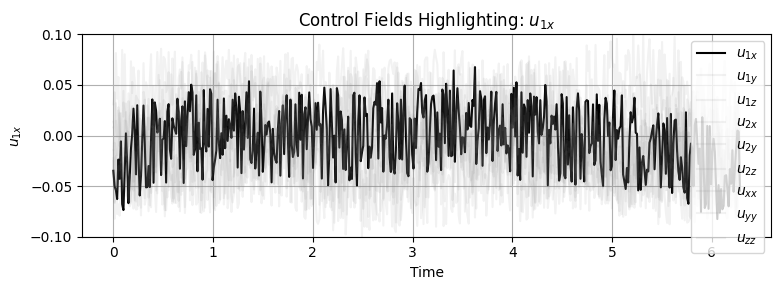

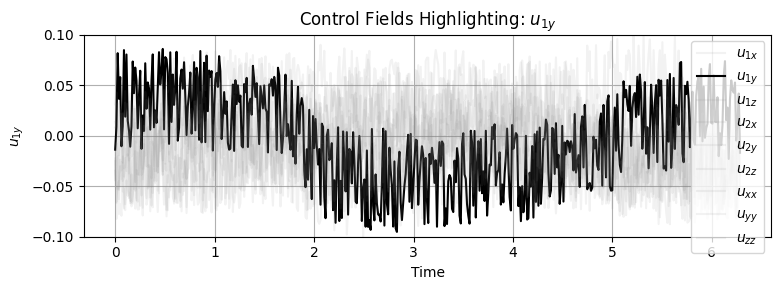

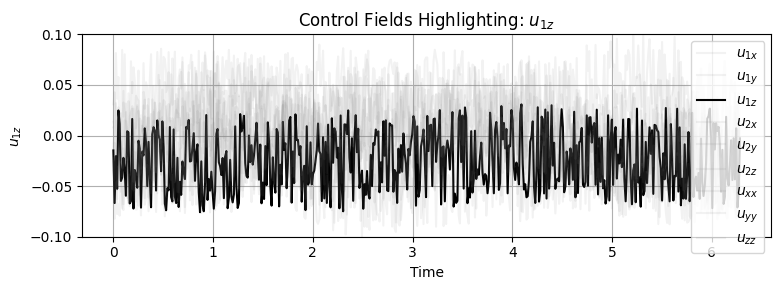

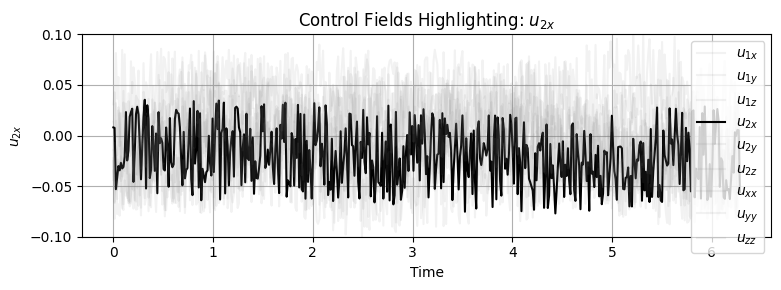

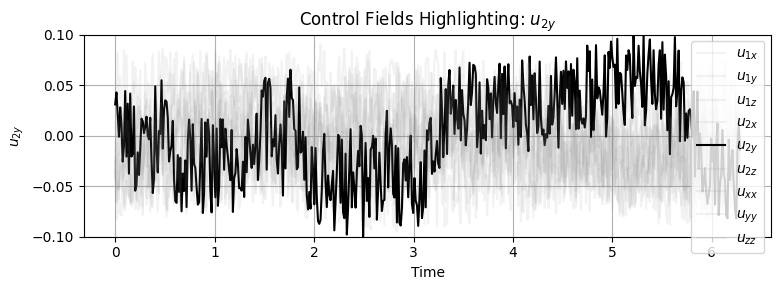

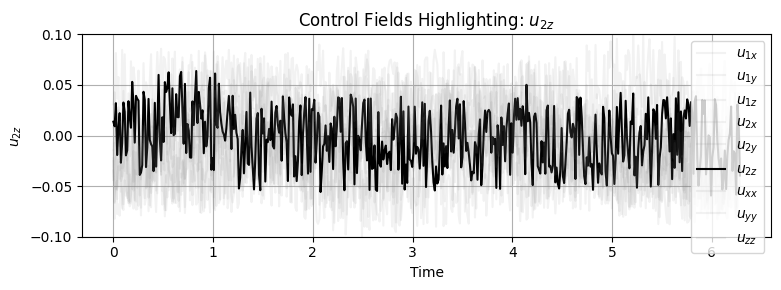

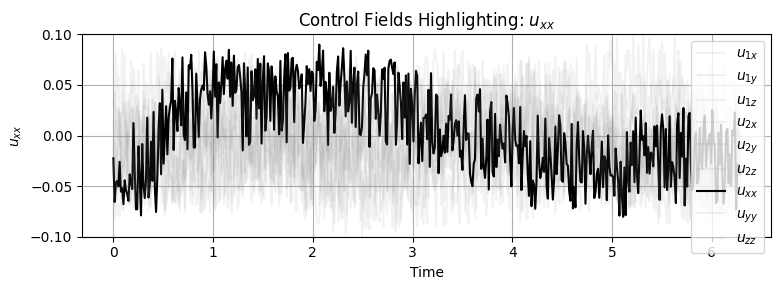

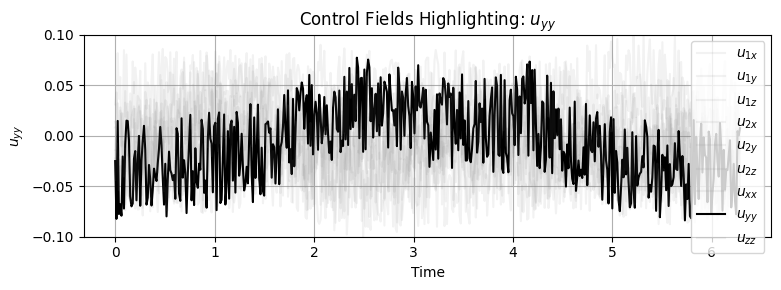

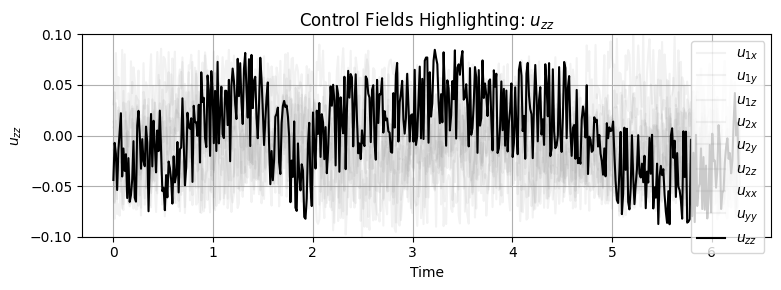

In [3]:
import matplotlib.pyplot as plt


def plot_control_amplitudes(times, final_amps, labels):
    num_controls = final_amps.shape[1]

    y_max = 0.1  # Fixed y-axis scale
    y_min = -0.1

    for i in range(num_controls):
        fig, ax = plt.subplots(figsize=(8, 3))

        for j in range(num_controls):
            color = (
                'black' if i == j else 'gray'
            )  # Highlight the current control
            alpha = 1.0 if i == j else 0.1
            ax.plot(
                times,
                final_amps[:, j],
                label=labels[j],
                color=color,
                alpha=alpha,
            )
        ax.set_title(f"Control Fields Highlighting: {labels[i]}")
        ax.set_xlabel("Time")
        ax.set_ylabel(labels[i])
        ax.set_ylim(y_min, y_max)  # Set fixed y-axis limits
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()


times = jnp.linspace(0, 2 * jnp.pi, 500)
H_labels = [
    r'$u_{1x}$',
    r'$u_{1y}$',
    r'$u_{1z}$',
    r'$u_{2x}$',
    r'$u_{2y}$',
    r'$u_{2z}$',
    r'$u_{xx}$',
    r'$u_{yy}$',
    r'$u_{zz}$',
]
plot_control_amplitudes(
    times, result.control_amplitudes / (2 * jnp.pi), H_labels
)

In [4]:
U_target = cnot()
U_f = result.final_operator

In [5]:
def overlap(U_target, U_f):
    """
    Calculate the overlap between the target unitary U_target and the final unitary U_f.

    Parameters:
    U_target (qutip.Qobj): Target unitary operator.
    U_f (qutip.Qobj): Final unitary operator.

    Returns:
    float: Real part of the overlap value.
    float: Fidelity (absolute square of the overlap).
    """
    # dividing over U_target.shape[0] is for normalization
    overlap_value = (
        jnp.trace(jnp.matmul(U_target.conj().T, U_f)) / U_target.shape[0]
    )
    fidelity = abs(overlap_value) ** 2
    return overlap_value.real, fidelity


# Example usage
overlap_real, fidelity = overlap(U_target, U_f)
print(f"Overlap (real part): {overlap_real}")
print(f"Fidelity: {fidelity}")

Overlap (real part): 0.7071028736035019
Fidelity: 0.9999889463518882
